In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
topic_list = [{
"topic": "software",
"fundraising_history": [200, 240, 320, 290, 310, 450, 330, 600, 530, 450]
},
{
"topic": "car",
"fundraising_history": [150, 190, 270, 280, 290, 310, 500, 420, 390, 420]
},
{
"topic": "autonomous car",
"fundraising_history": [0, 0, 10, 30, 80, 100, 120, 300, 250, 260]
},
{
"topic": "food waste",
"fundraising_history": [0, 4, 3, 0, 2, 10, 15, 20, 25, 40]
},
{
"topic": "mp3",
"fundraising_history": [200, 170, 100, 60, 20, 3, 8, 10, 4, 10]
},
{
"topic": "covid",
"fundraising_history": [0, 0, 0, 0, 0, 0, 0, 0, 1, 4]
}]

In [3]:
#convert into dataframe
df = pd.DataFrame()
for value in topic_list:
    df[value["topic"]]=value["fundraising_history"]

In [4]:
#add years as index
x=[]
for i in range(2011,2021):
    x.append(datetime.datetime.strptime(str(i), "%Y"))
df.index = x

In [5]:
df.head(10)

software  car  autonomous car  food waste  mp3  covid
2011-01-01       200  150               0           0  200      0
2012-01-01       240  190               0           4  170      0
2013-01-01       320  270              10           3  100      0
2014-01-01       290  280              30           0   60      0
2015-01-01       310  290              80           2   20      0
2016-01-01       450  310             100          10    3      0
2017-01-01       330  500             120          15    8      0
2018-01-01       600  420             300          20   10      0
2019-01-01       530  390             250          25    4      1
2020-01-01       450  420             260          40   10      4

The covid has 2 values different from 0 so it might be relevant to considere covid like a feature which influence the others topics until we have more data.

In [6]:
df.corr()

software       car  autonomous car  food waste       mp3  \
software        1.000000  0.684003        0.914598    0.713841 -0.750986   
car             0.684003  1.000000        0.770921    0.721600 -0.846168   
autonomous car  0.914598  0.770921        1.000000    0.874234 -0.718746   
food waste      0.713841  0.721600        0.874234    1.000000 -0.582010   
mp3            -0.750986 -0.846168       -0.718746   -0.582010  1.000000   
covid           0.317465  0.367317        0.542832    0.833670 -0.294912   

                   covid  
software        0.317465  
car             0.367317  
autonomous car  0.542832  
food waste      0.833670  
mp3            -0.294912  
covid           1.000000

We can see that software is positively correlated with autonomous car but as we have to few data we cannot conclude about this correlation.
More, we observe that covid influence food waste according to the correletion matrix, but same as before, we don't have enough data to conclude on it.

We will assume that all topics are independant and that covid don't affect them, but in reality, we can expect an influence on them.


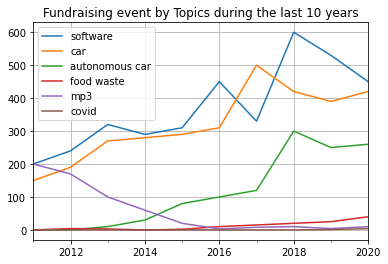

In [7]:
df.plot()
plt.title("Fundraising event by Topics during the last 10 years");
plt.grid()

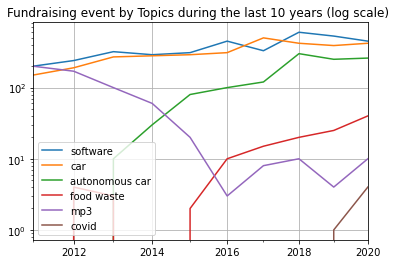

In [8]:
df.plot(loglog=True)
plt.title("Fundraising event by Topics during the last 10 years (log scale) ");
plt.grid()

### As we can see software, car and autonomous car represente the bigger volumes and are uptrending but we can see that food waste seems to be the upwarding too. We can see that the data are not stationary during the ten years


We can look at the growth of each topics during the ten years

In [9]:
df_croissance = pd.DataFrame()
for x in df:
    temp_list=[]
    for i in range(0, df.shape[0]-1):
        if df[x].iloc[i]!=0:
            temp_list.append(((df[x].iloc[i+1]-df[x].iloc[i])/df[x].iloc[i])*100)
        else :
            temp_list.append(0)
    df_croissance[x] = temp_list

In [10]:
del df_croissance["covid"] #we can delete covid topics in the first place
df_croissance.head()

software        car  autonomous car  food waste        mp3
0  20.000000  26.666667        0.000000         0.0 -15.000000
1  33.333333  42.105263        0.000000       -25.0 -41.176471
2  -9.375000   3.703704      200.000000      -100.0 -40.000000
3   6.896552   3.571429      166.666667         0.0 -66.666667
4  45.161290   6.896552       25.000000       400.0 -85.000000

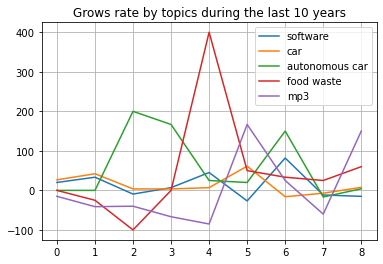

In [11]:
df_croissance.plot()
plt.title("Grows rate by topics during the last 10 years");
plt.grid()

In [12]:
list_croissance_mean = [np.mean(df_croissance[x]) for x in df_croissance]
df_croissance_mean=pd.DataFrame(columns=['Software','Car', 'Autonomous car','Food waste', 'Mp3'])
df_croissance_mean.loc[0,:]=list_croissance_mean

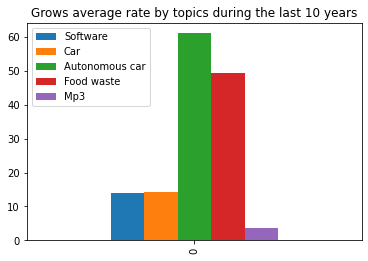

In [13]:
df_croissance_mean.plot.bar()
plt.title("Grows average rate by topics during the last 10 years");


### In average, when we look at the variation rate, we can see that food waste, car and autonomous car are the topics that are the most increasing  during the 10 years.

## Forecasting

### We will use a Arima model to forecast, to do this, we will make the data stationnary with the method of difference 

In [14]:
dataset_software = df["software"]
dataset_car = df["car"]
dataset_autonomous_car = df["autonomous car"]
dataset_food_waste = df["food waste"]
dataset_mp3 = df["mp3"]

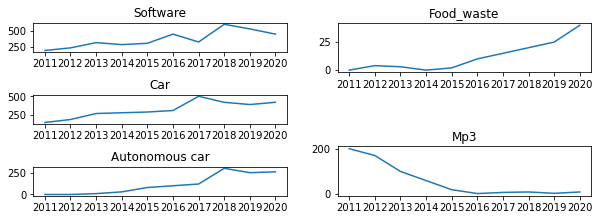

In [15]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(321)
ax2 = f.add_subplot(323)
ax3 = f.add_subplot(325)
ax4 = f.add_subplot(222)
ax5 = f.add_subplot(224)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 1.5  
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax.plot(dataset_software)
ax.title.set_text('Software')

ax2.plot(dataset_car)
ax2.title.set_text('Car')
ax3.plot(dataset_autonomous_car)
ax3.title.set_text('Autonomous car')
ax4.plot(dataset_food_waste)
ax4.title.set_text('Food_waste')
ax5.plot(dataset_mp3)
ax5.title.set_text('Mp3')

In [16]:

diff_software = dataset_software.diff()
diff_software=diff_software.iloc[1:]
diff_car = dataset_car.diff()
diff_car=diff_car.iloc[1:]

diff_autonomous_car = dataset_autonomous_car.diff()
diff_autonomous_car=diff_autonomous_car.iloc[1:]

diff_food_waste = dataset_food_waste.diff()
diff_food_waste=diff_food_waste.iloc[1:]

diff_mp3 = dataset_mp3.diff()
diff_mp3=diff_mp3.iloc[1:]

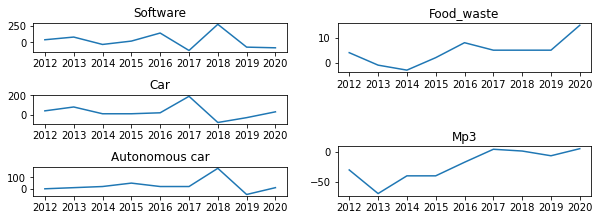

In [17]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(321)
ax2 = f.add_subplot(323)
ax3 = f.add_subplot(325)
ax4 = f.add_subplot(222)
ax5 = f.add_subplot(224)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 1.5  
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax.plot(diff_software)
ax.title.set_text('Software')

ax2.plot(diff_car)
ax2.title.set_text('Car')
ax3.plot(diff_autonomous_car)
ax3.title.set_text('Autonomous car')
ax4.plot(diff_food_waste)
ax4.title.set_text('Food_waste')
ax5.plot(diff_mp3)
ax5.title.set_text('Mp3')

### The topics seems more stationnary 

### Gridsearch

In [20]:
def evaluate_arima_model(datasets,diffs,name, arima_order):
    
    
    history = (diff).iloc[0:6]
    predictions = list()
    date_predict = []
    y_predit=[]
    # walk-forward validation
    for t in range(len(dataset.iloc[6:])):
        x = "model_"+ name
        models_dict[x] = ARIMA(history, order=arima_order)
        models_dict[x] = models_dict[x].fit()
        output = models_dict[x].forecast()[0]
        output=output+dataset.iloc[5+t]
        yhat = output
        predictions.append(yhat)
        obs = dataset.iloc[6+t]
        #history = np.append(history, obs)
        history.loc[dataset.index.values[6+t]]=obs#to retrieve the normal value
        date_predict.append(dataset.index.values[6+t])
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(dataset.iloc[6:], predictions[:]))
    return rmse

def evaluate_models(datasets,diffs,name, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(datasets,diffs,name, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s for %s RMSE=%.3f' % (best_cfg,name, best_score))
    
datasets = [dataset_software,dataset_car,dataset_autonomous_car, dataset_food_waste, dataset_mp3]
diffs =  [diff_software,diff_car, diff_autonomous_car, diff_food_waste, diff_mp3]
names = ["software", "car","autonomous_car","food_waste","mp3"]
models_dict = {}
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

for dataset, diff, name in zip(datasets,diffs,names):
    evaluate_models(dataset,diff,name, p_values, d_values, q_values)
        

ARIMA(0, 0, 0) RMSE=219.840
ARIMA(0, 0, 1) RMSE=352.617
ARIMA(0, 1, 0) RMSE=506.730
ARIMA(0, 1, 1) RMSE=537.415
ARIMA(0, 1, 2) RMSE=577.696
ARIMA(0, 2, 0) RMSE=641.736
ARIMA(0, 2, 1) RMSE=669.221
ARIMA(0, 2, 2) RMSE=637.923
ARIMA(1, 0, 0) RMSE=446.462
ARIMA(1, 0, 1) RMSE=454.779
ARIMA(1, 1, 0) RMSE=595.254
ARIMA(1, 1, 1) RMSE=553.550
ARIMA(1, 1, 2) RMSE=539.123
ARIMA(1, 2, 0) RMSE=667.839
ARIMA(1, 2, 1) RMSE=646.692
ARIMA(1, 2, 2) RMSE=632.958
ARIMA(2, 0, 0) RMSE=494.323
ARIMA(2, 0, 1) RMSE=498.287
ARIMA(2, 1, 0) RMSE=578.414
ARIMA(2, 1, 1) RMSE=587.589
ARIMA(2, 1, 2) RMSE=552.838
ARIMA(2, 2, 0) RMSE=691.797
ARIMA(2, 2, 1) RMSE=613.056
ARIMA(2, 2, 2) RMSE=619.921
ARIMA(4, 0, 0) RMSE=522.028
ARIMA(4, 0, 1) RMSE=516.861
ARIMA(4, 1, 0) RMSE=502.163
ARIMA(4, 1, 1) RMSE=552.430
ARIMA(4, 1, 2) RMSE=509.581
ARIMA(4, 2, 0) RMSE=502.855
ARIMA(4, 2, 1) RMSE=466.178
ARIMA(4, 2, 2) RMSE=510.963
ARIMA(6, 0, 0) RMSE=459.817
ARIMA(6, 0, 1) RMSE=513.361
ARIMA(6, 1, 0) RMSE=490.466
ARIMA(6, 1, 1) RMSE=

predicted=546.666661, expected=330.000000
predicted=426.666661, expected=600.000000
predicted=768.571405, expected=530.000000
predicted=743.749998, expected=450.000000
Test RMSE: 234.624


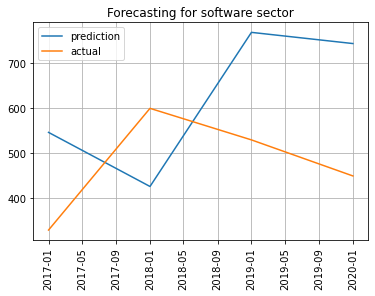

predicted=419.999992, expected=500.000000
predicted=609.999992, expected=420.000000
predicted=574.285712, expected=390.000000
predicted=573.749994, expected=420.000000
Test RMSE: 158.193


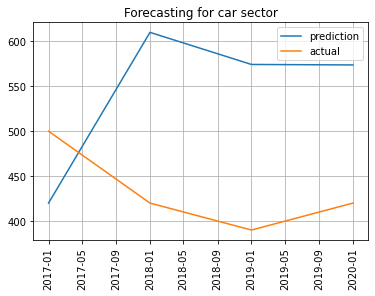

predicted=136.666662, expected=120.000000
predicted=156.666662, expected=300.000000
predicted=374.285708, expected=250.000000
predicted=346.249996, expected=260.000000
Test RMSE: 104.533


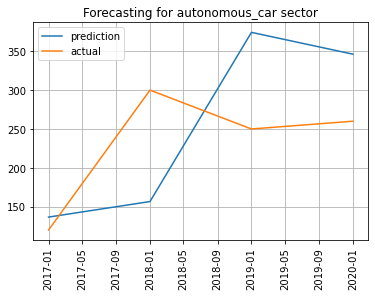

predicted=14.166661, expected=15.000000
predicted=19.166661, expected=20.000000
predicted=26.428567, expected=25.000000
predicted=33.749995, expected=40.000000
Test RMSE: 3.259


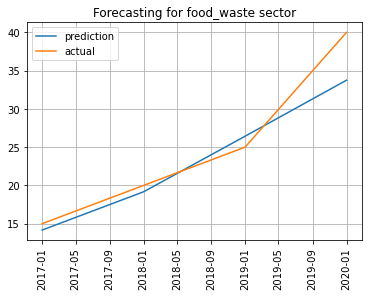

predicted=5.613743, expected=8.000000
predicted=10.613743, expected=10.000000
predicted=19.231734, expected=4.000000
predicted=8.753747, expected=10.000000
Test RMSE: 7.740


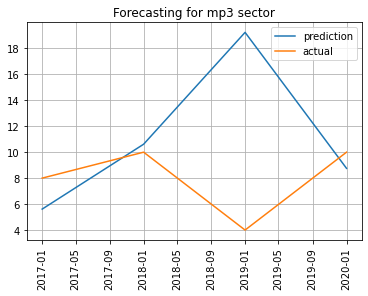

In [21]:
datasets = [dataset_software,dataset_car,dataset_autonomous_car, dataset_food_waste, dataset_mp3]
diffs =  [diff_software,diff_car, diff_autonomous_car, diff_food_waste, diff_mp3]
names = ["software", "car","autonomous_car","food_waste","mp3"]
models_dict = {}
for dataset, diff, name in zip(datasets,diffs,names):
    history = (diff).iloc[0:6]
    predictions = list()
    date_predict = []
    y_predit=[]
    # walk-forward validation
    for t in range(len(dataset.iloc[6:])):
        x = "model_"+ name
        if name == "software":  
            models_dict[x] = ARIMA(history, order=(0, 0, 0))
        if name == "car":  
            models_dict[x] = ARIMA(history, order=(0, 0, 0))
        if name == "autonomous_car":  
            models_dict[x] = ARIMA(history, order=(0, 0, 0))
        if name == "food_waste":  
            models_dict[x] = ARIMA(history, order=(0, 0, 0))
        if name == "mp3":  
            models_dict[x] = ARIMA(history, order=(0, 1, 1))
        models_dict[x] = models_dict[x].fit()
        output = models_dict[x].forecast()[0]
        output=output+dataset.iloc[5+t]
        yhat = output
        predictions.append(yhat)
        obs = dataset.iloc[6+t]
        #history = np.append(history, obs)
        history.loc[dataset.index.values[6+t]]=obs#to retrieve the normal value
        date_predict.append(dataset.index.values[6+t])
        print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(dataset.iloc[6:], predictions[:]))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes

    plt.plot(date_predict,predictions[:], label='prediction')
    plt.plot(dataset.iloc[6:], label='actual')
    plt.title('Forecasting for ' + name + ' sector')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=90)
    plt.show()

### To improve the model we could try others models, optimize their hyperparameters and add data

In [22]:
for name in names:
    output = models_dict["model_"+ name].forecast()[0]
    print("The number of fundraising event for "+name+ " sector for the year 2021 is " + str(round(output,2)))

The number of fundraising event for software sector for the year 2021 is 213.75
The number of fundraising event for car sector for the year 2021 is 183.75
The number of fundraising event for autonomous_car sector for the year 2021 is 96.25
The number of fundraising event for food_waste sector for the year 2021 is 8.75
The number of fundraising event for mp3 sector for the year 2021 is 4.75
